In [1]:
# Cell 1 — imports & regex
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
import tifffile
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # remove decompression-limit check


_SAMPLE_ID_RE = re.compile(r"25-00(\d+)_")

def _parse_sample_id(fname):
    """Extracts the integer sample ID from filenames like '25-001_foo.tif'."""
    m = _SAMPLE_ID_RE.search(os.path.basename(fname))
    if not m:
        raise ValueError(f"Can't parse sample ID from {fname!r}")
    return int(m.group(1))


In [2]:
# Cell 2 — discover filepaths
def _collect_mask_paths(input_folder):
    """Returns a dict sample_id → dict of the three mask paths."""
    base = Path(input_folder)
    masks = {"cell": base/"cell_masks", "nucleus": base/"nucleus_masks", "mito": base/"mitos-binary", "ld": base/"lds-binary"}
    samples = {}
    for kind, folder in masks.items():
        for fp in folder.glob("*.tif"):
            if "25-0081_5nm_R7_bsd.tif" in fp.name:
                continue
            sid = _parse_sample_id(fp.name)
            samples.setdefault(sid, {})[kind] = fp
    # sanity check
    for sid, d in samples.items():
        if set(d) != {"cell","nucleus","mito", "ld"}:
            raise RuntimeError(f"Missing mask(s) for sample {sid}: {d}")
    return samples

def _find_au_image(input_folder, sample_id):
    """Finds the 197Au.png for a given sample_id under isotopes_registered."""
    iso_root = Path(input_folder)/"isotopes_registered"
    # look for a subfolder starting with the zero-padded ID
    prefix = f"{sample_id:02d}"
    for sub in iso_root.iterdir():
        if sub.is_dir() and sub.name.startswith(prefix):
            candidate = sub/"197Au.png"
            if candidate.exists():
                return candidate
    raise FileNotFoundError(f"197Au.png not found for sample {sample_id}")


In [3]:
from skimage.measure import regionprops
import numpy as np
import pandas as pd

def _summarize_cells_for_sample(cell_mask, nucleus_mask, mito_mask, ld_mask, au_img, sample_id):
    """
    Fast per-cell summarization using bincount and regionprops.
    Returns a DataFrame with columns:
      sample_id, cell_label, cell_area, nucleus_count,
      nucleus_area, nucleus_frac, mito_frac, cyto_frac,
      cell_au_frac, nuc_au_frac, mito_au_frac, cyto_au_frac,
      au_nuc_pct, au_mito_pct, au_cyto_pct
    """
    # Flatten all our masks once
    flat_cell       = cell_mask.ravel()
    flat_nucleus    = (nucleus_mask.ravel() > 0)
    flat_mito_excl  = (mito_mask.ravel() > 0) & ~flat_nucleus
    flat_ld         = (ld_mask.ravel() > 0) & ~flat_mito_excl & ~flat_nucleus
    flat_au         = (au_img.ravel() > 0)

    max_label = int(flat_cell.max())

    # 1) Pixel counts per label
    area      = np.bincount(flat_cell,                      minlength=max_label+1)
    nuc_area  = np.bincount(flat_cell[flat_nucleus],        minlength=max_label+1)
    mito_area = np.bincount(flat_cell[flat_mito_excl],      minlength=max_label+1)
    ld_area   = np.bincount(flat_cell[flat_ld],            minlength=max_label+1)
    cyto_area = area - nuc_area - mito_area

    # 2) Au counts per label
    au_total = np.bincount(flat_cell[flat_au],               minlength=max_label+1)
    au_nuc   = np.bincount(flat_cell[flat_au & flat_nucleus],    minlength=max_label+1)
    au_mito  = np.bincount(flat_cell[flat_au & flat_mito_excl],  minlength=max_label+1)
    au_ld     = np.bincount(flat_cell[flat_au & flat_ld],        minlength=max_label+1)
    au_cyto  = au_total - au_nuc - au_mito - au_ld

    # 3) Count how many distinct nuclei land in each cell
    nuc_count = np.zeros(max_label+1, dtype=int)
    for prop in regionprops(nucleus_mask):
        y, x = map(int, prop.centroid)
        lab = int(cell_mask[y, x])
        if lab > 0:
            nuc_count[lab] += 1

    # 4) Assemble results for each real cell label
    records = []
    cell_labels = np.nonzero(area[1:])[0] + 1  # skip background=0
    for lab in cell_labels:
        A = area[lab]
        T = au_total[lab]
        nA, mA, cA, ldA = nuc_area[lab], mito_area[lab], cyto_area[lab], ld_area[lab]

        records.append({
            "sample_id":     sample_id,
            "cell_label":    lab,
            "cell_area":     A,
            "nucleus_count": nuc_count[lab],
            "nucleus_area":  nA,
            "nucleus_frac":  nA / A,
            "mito_frac":     mA / A,
            "ld_frac":       ldA / A,
            "cyto_frac":     cA / A,
            "cell_au_frac":  T / A,
            "nuc_au_frac":   au_nuc[lab]   / A,
            "mito_au_frac":  au_mito[lab]  / A,
            "ld_au_frac":    au_ld[lab]    / A,
            "cyto_au_frac":  au_cyto[lab]  / A,
            "au_nuc_pct":    np.nan if T==0 else au_nuc[lab]  / T,
            "au_mito_pct":   np.nan if T==0 else au_mito[lab] / T,
            "au_ld_pct":     np.nan if T==0 else au_ld[lab] / T,
            "au_cyto_pct":   np.nan if T==0 else au_cyto[lab] / T,
        })

    return pd.DataFrame.from_records(records)


In [4]:
import numpy as np
import tifffile
from pathlib import Path
import pandas as pd
from PIL import Image

# ─── Helper: pad or crop to target_shape ────────────────────────────────────────
def _resize_to(img: np.ndarray, target_shape: tuple[int,int]) -> np.ndarray:
    """
    Pads with zeros or crops on bottom/right so that
    `img.shape == target_shape`.
    """
    h_tgt, w_tgt = target_shape
    h, w = img.shape
    if img.shape == target_shape:
        return img

    # crop if too big
    h_crop = min(h, h_tgt)
    w_crop = min(w, w_tgt)
    img = img[:h_crop, :w_crop]

    # pad if too small
    pad_h = h_tgt - h_crop
    pad_w = w_tgt - w_crop
    if pad_h > 0 or pad_w > 0:
        img = np.pad(
            img,
            ((0, pad_h), (0, pad_w)),
            mode="constant",
            constant_values=0
        )
    return img

# ─── (Re-)define load_all_cells with resizing ──────────────────────────────────
def load_all_cells(input_folder: str) -> pd.DataFrame:
    """
    Scans the input_folder and returns a DataFrame
    with one row per cell, with all the metrics described.
    Automatically pads/crops the cell & nucleus masks
    to match your mito_mask (and Au image) shape.
    """
    samples = _collect_mask_paths(input_folder)
    all_dfs = []

    for sid, paths in samples.items():
        print(sid)
        # 1) load masks
        cell_mask_raw    = tifffile.imread(paths["cell"])
        nucleus_mask_raw = tifffile.imread(paths["nucleus"])
        mito_mask        = tifffile.imread(paths["mito"]) > 0
        ld_mask           = tifffile.imread(paths["ld"]) > 0

        # 2) ensure shapes match by resizing cell & nucleus masks to mito_mask.shape
        target_shape = mito_mask.shape
        cell_mask    = _resize_to(cell_mask_raw,    target_shape)
        nucleus_mask = _resize_to(nucleus_mask_raw, target_shape)

        # 3) load Au image (you can disable PIL bomb or use tifffile here)
        au_path = _find_au_image(input_folder, sid)
        # option A: disable PIL limit at top of notebook:
        #     from PIL import Image; Image.MAX_IMAGE_PIXELS=None
        # au_img = np.array(Image.open(au_path))
        # option B: use tifffile directly:
        au_img = np.array(Image.open(au_path))

        # 4) summarize this sample
        df = _summarize_cells_for_sample(
            cell_mask=cell_mask,
            nucleus_mask=nucleus_mask,
            mito_mask=mito_mask.astype(np.uint8),
            ld_mask=ld_mask.astype(np.uint8),
            au_img=au_img,
            sample_id=sid
        )
        all_dfs.append(df)

    # 5) concatenate and return
    return pd.concat(all_dfs, ignore_index=True)


In [5]:
df = load_all_cells("/Volumes/Chris_SSD/ImmunoEM-Analysis")
df.to_csv("./gck-immunoem-cells2.csv")

73
75
77
79
81
83
85
87
89


In [25]:
#df.to_csv("./gck-immunoem-cells.csv")
df = pd.read_csv("./gck-immunoem-cells2.csv")

In [26]:
print(df.shape)

(578, 19)


In [27]:
import matplotlib.pyplot as plt
import numpy as np

def plot_group_violins(df, column, plot_type='cell', nucleus_required=False):
    """
    Creates side-by-side violin plots for three experimental groups:
      - '6hr fast': samples 73, 75, 77
      - '1hr glucose': samples 79, 81, 83
      - 'ON fast': samples 85, 87, 89

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain 'sample_id' and the specified column.
    column : str
        Name of the numeric column to plot.
    plot_type : {'cell', 'animal'}
        - 'cell': use individual cell values, color-coded by sample.
        - 'animal': average per sample_id; violin has 3 values per group.
    """
    if nucleus_required:
        df = df[df.get('nucleus_count', 0) > 0]
    # define which sample IDs belong to each group
    group_map = {
        '6hr fast': [73, 75, 77],
        '1hr glucose': [79, 81, 83],
        'ON fast': [85, 87, 89]
    }
    groups = list(group_map.keys())
    data = []

    if plot_type == 'cell':
        # collect the raw cell-level values for each group
        for grp in groups:
            ids = group_map[grp]
            vals = df.loc[df['sample_id'].isin(ids), column].values
            print(grp, vals.shape)
            data.append(vals)
        

        fig, ax = plt.subplots()
        ax.violinplot(data,
                      positions=range(len(groups)),
                      showmeans=False,
                      showmedians=True)
        ax.set_xticks(range(len(groups)))
        ax.set_xticklabels(groups)
        ax.set_ylabel(column)

        # assign each sample its own color
        unique_ids = sorted(df['sample_id'].unique())
        cmap = plt.get_cmap('tab10', len(unique_ids))
        id_to_color = {sid: cmap(i) for i, sid in enumerate(unique_ids)}

        # overlay individual points with jitter
        for i, grp in enumerate(groups):
            ids = group_map[grp]
            sub = df[df['sample_id'].isin(ids)]
            jitter = 0.08
            x = np.random.rand(len(sub)) * jitter + i
            y = sub[column]
            colors = [id_to_color[sid] for sid in sub['sample_id']]
            ax.scatter(x, y, c=colors, s=10)

        plt.tight_layout()
        plt.show()

    elif plot_type == 'animal':
        # average per sample_id first, then build the group lists
        avg = df.groupby('sample_id')[column].mean().dropna().reset_index()
        for grp in groups:
            ids = group_map[grp]
            vals = avg.loc[avg['sample_id'].isin(ids), column].values
            print(grp, vals)
            data.append(vals)

        fig, ax = plt.subplots()
        ax.violinplot(data,
                      positions=range(len(groups)),
                      showmeans=False,
                      showmedians=True)
        ax.set_xticks(range(len(groups)))
        ax.set_xticklabels(groups)
        ax.set_ylabel(column)
        plt.tight_layout()
        plt.show()

    else:
        raise ValueError("plot_type must be 'cell' or 'animal'")

# Example usage:
# plot_group_violins(df, 'cell_area', 'cell')
# plot_group_violins(df, 'cell_area', 'animal')


6hr fast [0.0434807  0.05392117 0.04761344]
1hr glucose [0.06878316 0.06449409 0.0649216 ]
ON fast [0.04109618 0.04900719 0.03076336]


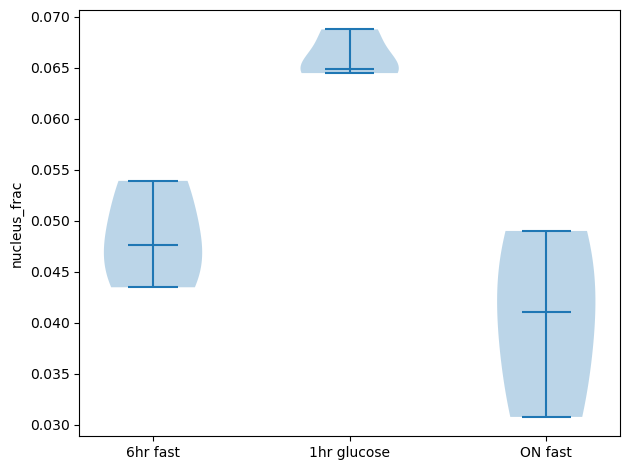

6hr fast [0.14856173 0.14481344 0.17735298]
1hr glucose [0.10021407 0.10751728 0.08689529]
ON fast [0.19500472 0.1793458  0.15160876]


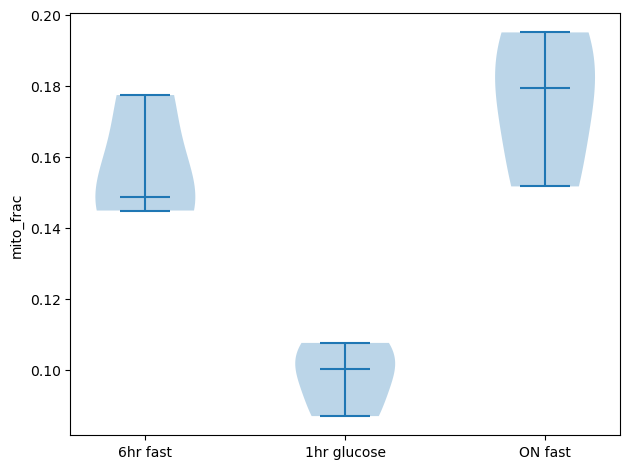

6hr fast [0.80795758 0.80126539 0.77503359]
1hr glucose [0.83100277 0.82798863 0.8481831 ]
ON fast [0.76389911 0.77164701 0.81762789]


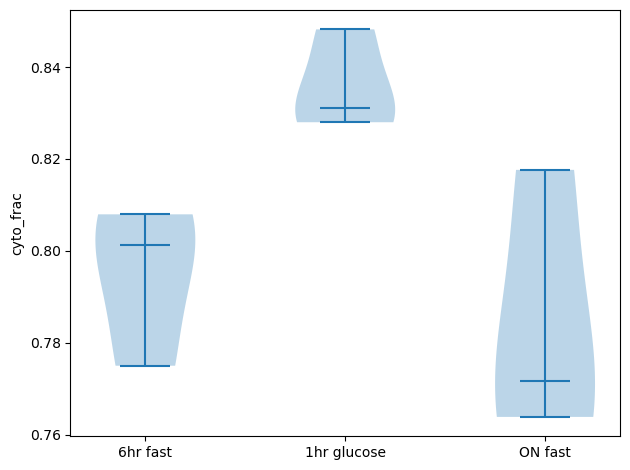

6hr fast [0.0830745  0.07025014 0.05505092]
1hr glucose [0.19747507 0.17786994 0.0981011 ]
ON fast [0.10747143 0.13670282 0.17111892]


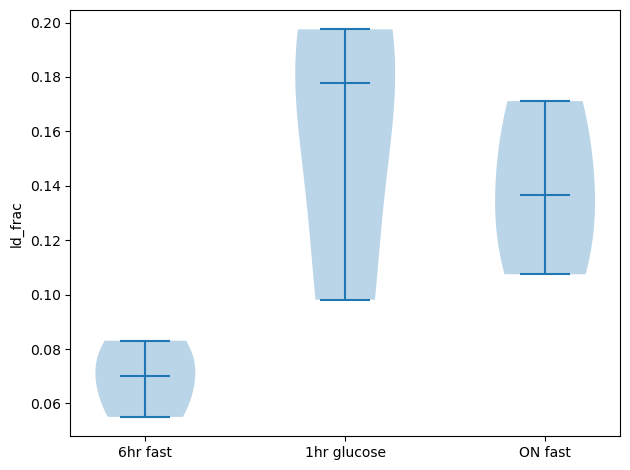

In [28]:
import pandas as pd

df = pd.read_csv("./gck-immunoem-cells2.csv")

"""{
            "sample_id": sample_id,
            "cell_label": lab,
            "cell_area": cell_area,
            "nucleus_count": nucleus_count,
            "nucleus_area": nucleus_area,
            "nucleus_frac": nuc_frac,
            "mito_frac": mito_frac,
            "cyto_frac": cyto_frac,
            "cell_au_frac": cell_au_frac,
            "nuc_au_frac": nuc_au_frac,
            "mito_au_frac": mito_au_frac,
            "cyto_au_frac": cyto_au_frac,
            "au_nuc_pct": au_nuc_pct,
            "au_mito_pct": au_mito_pct,
            "au_cyto_pct": au_cyto_pct,
        })"""
plot_group_violins(df, 'nucleus_frac', 'animal', nucleus_required=False)
plot_group_violins(df, 'mito_frac', 'animal', nucleus_required=False)
plot_group_violins(df, 'cyto_frac', 'animal', nucleus_required=False)
plot_group_violins(df, 'ld_frac', 'animal', nucleus_required=False)



6hr fast [1.68991175 2.58149217 1.21684991]
1hr glucose [0.96214156 1.56795779 0.9015639 ]
ON fast [3.03965934 1.68620043 2.90166798]


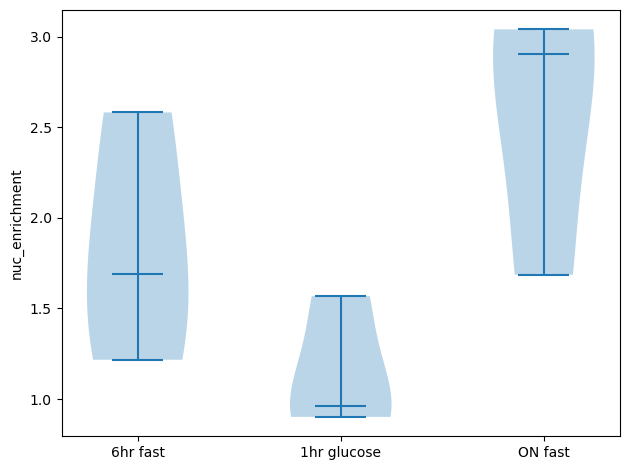

6hr fast (56,)
1hr glucose (71,)
ON fast (111,)


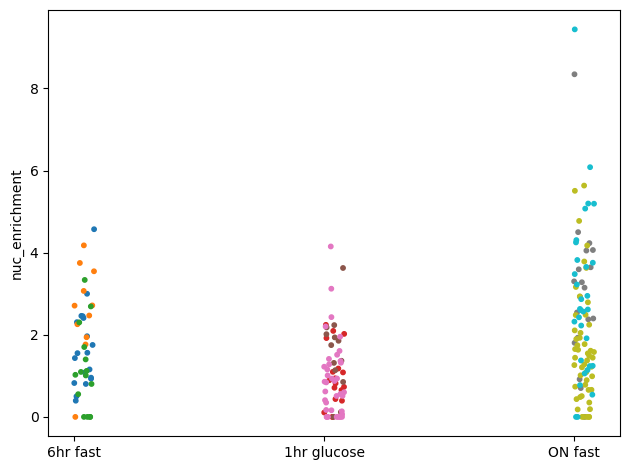

In [29]:

df = df[df['nucleus_frac'] > 0]  # drop cells with no nucleus
df['nuc_enrichment'] = df['au_nuc_pct'] / df['nucleus_frac']

# 2) plot at the animal level
plot_group_violins(df, 'nuc_enrichment', plot_type='animal', nucleus_required=True)

# 3) if you also want cell‐level
plot_group_violins(df, 'nuc_enrichment', plot_type='cell')

6hr fast [0.99000397 1.28824556 1.05157122]
1hr glucose [1.15209224 1.21407413 1.56281141]
ON fast [0.77419807 0.82271218 0.63325133]


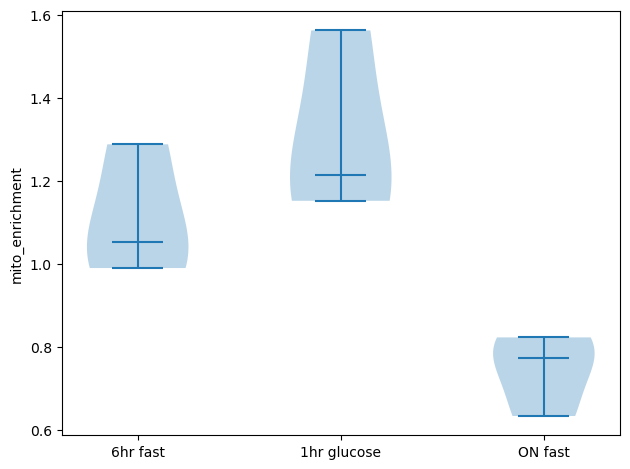

6hr fast (56,)
1hr glucose (71,)
ON fast (111,)


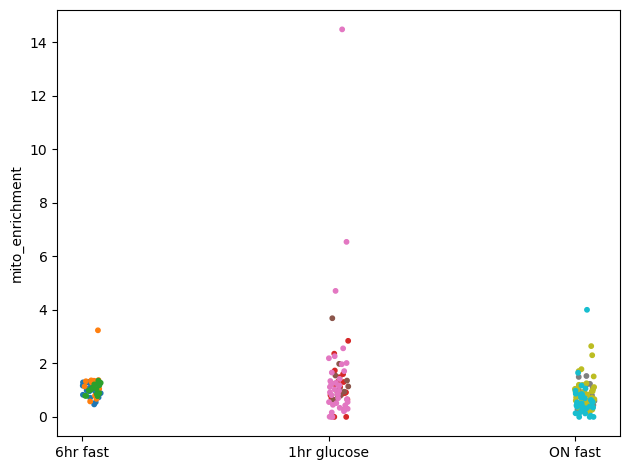

In [30]:

df = df[df['mito_frac'] > 0]  # drop cells with no nucleus
df['mito_enrichment'] = df['au_mito_pct'] / df['mito_frac']

# 2) plot at the animal level
plot_group_violins(df, 'mito_enrichment', plot_type='animal', nucleus_required=True)

# 3) if you also want cell‐level
plot_group_violins(df, 'mito_enrichment', plot_type='cell')

6hr fast [0.86472054 0.72736189 0.90937015]
1hr glucose [0.8659318  0.80519951 0.89053635]
ON fast [0.67445225 0.7835214  0.59090498]


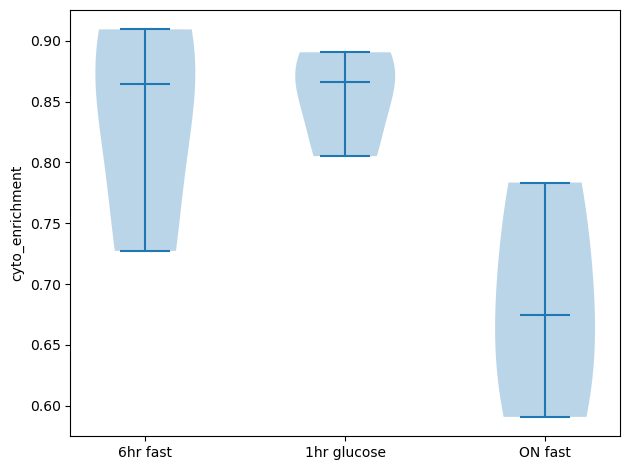

6hr fast (56,)
1hr glucose (71,)
ON fast (111,)


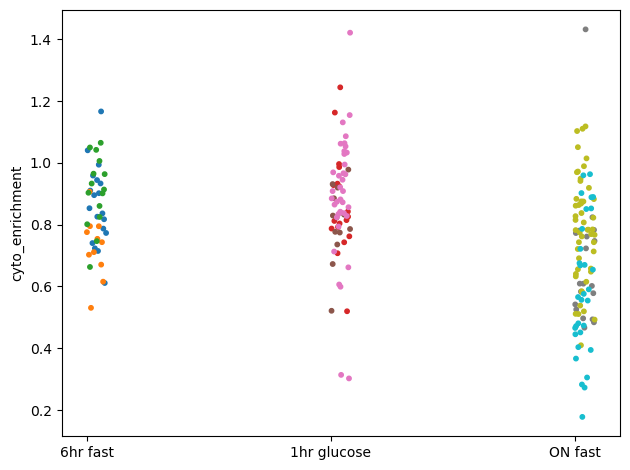

In [31]:

df = df[df['cyto_frac'] > 0]  # drop cells with no nucleus
df['cyto_enrichment'] = df['au_cyto_pct'] / df['cyto_frac']

# 2) plot at the animal level
plot_group_violins(df, 'cyto_enrichment', plot_type='animal', nucleus_required=False)

# 3) if you also want cell‐level
plot_group_violins(df, 'cyto_enrichment', plot_type='cell')

6hr fast [0.7533726  0.57577981 0.60756181]
1hr glucose [0.46390782 0.42768897 0.70825204]
ON fast [0.60696091 0.9309997  0.85942366]


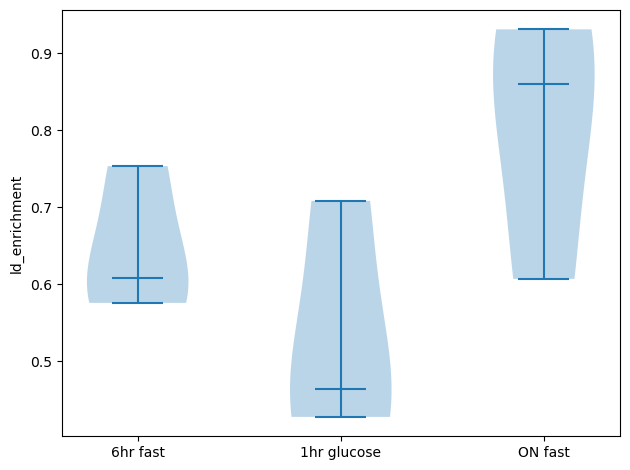

6hr fast (56,)
1hr glucose (71,)
ON fast (111,)


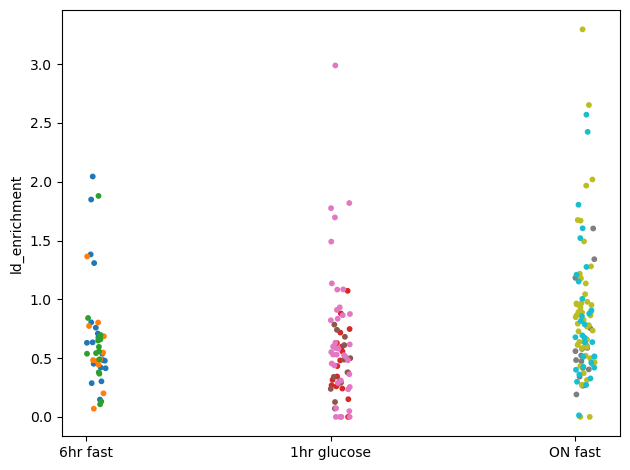

In [32]:
df = df[df['ld_frac'] > 0]  # drop cells with no nucleus
df['ld_enrichment'] = df['au_ld_pct'] / df['ld_frac']

# 2) plot at the animal level
plot_group_violins(df, 'ld_enrichment', plot_type='animal', nucleus_required=False)

# 3) if you also want cell‐level
plot_group_violins(df, 'ld_enrichment', plot_type='cell')